**Binary Classification**

In [4]:
!pip install shap
!pip install category_encoders
!pip install vecstack

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394162 sha256=f097e3fc38c512f1b3aabe064e1a7fb97dc221872526713def73584dc884dffc
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 102kB 2.3MB/s 
  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19877 sha256=2e94c69dfe8eb221e8cd6627e13152c179ea7924770caeb2dc6faa5bbd7fd751
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

import shap
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, \
                                    StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder

from pprint import pprint

from vecstack import StackingTransformer

RANDOM_STATE = 1805

In [0]:
train_data = pd.read_csv('/content/drive/My Drive/HACKATHON DAUPHINE/Data/ref_train_x.csv')
train_labels = pd.read_csv('/content/drive/My Drive/HACKATHON DAUPHINE/Data/ref_train_y.csv', header=None)
test_data = pd.read_csv('/content/drive/My Drive/HACKATHON DAUPHINE/Data/ref_test_x.csv')

# sp500_valid_data.columns = sp500_train_data.columns
# sp500_test_data.columns = sp500_train_data.columns

In [0]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(15249, 22)
(15249, 1)
(4191, 23)


In [0]:
train_data.head()

,sector,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio
0,4700,3.7452,-0.3692,-0.0972,2.2375,1.1495,22.1040,17.1714,0.787627,0.884178,1.401695,0.516182,364.0,US,0.018193,1.011748,0.924447,0.306404,0.196460,1.000361,0.245411,265.517241
1,4700,3.2026,-0.6008,0.6127,3.3098,1.3508,17.5971,15.9524,0.939068,0.833054,1.370815,0.540048,66.0,US,0.065461,0.998823,0.836746,0.280513,0.173050,0.950767,0.225520,72.325581
2,4700,4.4641,1.6247,-5.4056,-0.6884,-2.3511,6.2714,16.4591,0.959970,0.714396,0.907072,0.558759,255.0,US,0.065711,1.002628,0.839933,0.281582,0.173709,0.954389,0.226379,72.325581
3,4700,5.4850,0.3439,-0.4482,1.5906,5.5010,9.4912,15.9525,0.503026,0.593907,0.877211,0.798445,358.0,US,0.064607,0.985790,0.825828,0.276853,0.170792,0.938362,0.222578,72.325581
4,4700,2.3555,0.4032,-1.2826,1.4269,4.4619,17.4692,14.4131,0.947279,0.994358,0.876525,0.693418,62.0,US,-0.111328,0.756207,0.759751,0.252945,0.154876,0.779753,0.197967,72.325581


In [0]:
train_data.groupby('sector').count()

,earnings_implied_obs,delta_vol_1w,delta_vol_1y,return_1w,return_1m,return_1y,implied_vol_3m,realised_vol_1w,realised_vol_1m,realised_vol_1y,ratio_put_call,publication_date_funda,exchange,net_income,shareholders_equity,net_debt,ebitda,ebit,sales,cash_flow,payout_ratio
sector,,,,,,,,,,,,,,,,,,,,,
1100,508,512,505,512,512,512,512,512,512,512,509,512,512,512,512,512,512,512,512,512,505
1200,1073,1075,1061,1076,1076,1076,1076,1076,1076,1076,1073,1076,1076,1076,1076,1076,1076,1076,1076,1076,1073
1300,1214,1214,1211,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214,1214
1400,569,569,562,569,569,569,569,569,569,569,568,569,569,569,569,568,569,569,569,569,569
2100,642,642,635,642,642,642,642,642,642,642,639,642,642,642,642,642,642,642,642,642,634
2200,745,749,739,749,749,749,749,749,749,749,744,749,749,749,749,749,749,749,749,748,748
2300,1079,1079,1055,1079,1079,1079,1079,1079,1079,1079,1074,1079,1079,1079,1079,1079,1079,1079,1079,1079,1074
2400,1043,1043,1038,1043,1043,1043,1043,1043,1043,1043,1030,1043,1043,1043,1043,1043,1043,1043,1043,1043,1042
3100,545,546,531,547,547,547,547,547,547,547,544,536,547,536,532,536,536,536,536,532,532


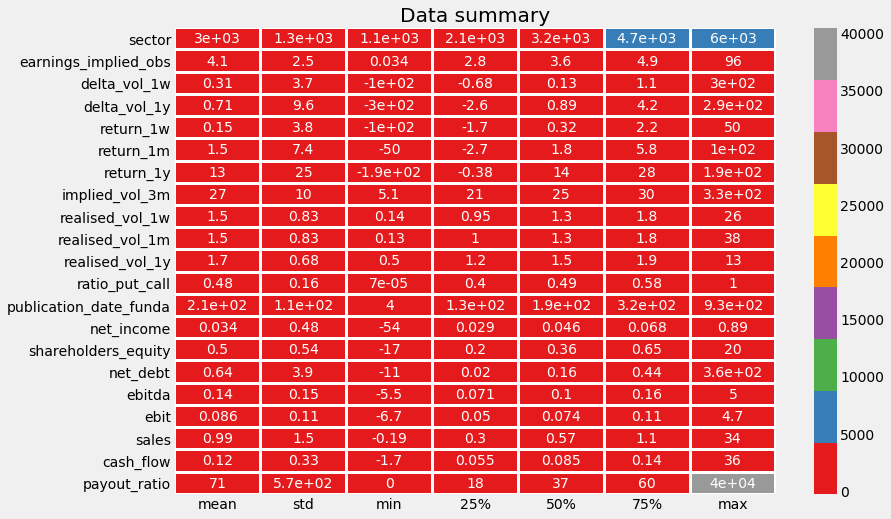

In [0]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.describe()[1:].transpose(),
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Set1"))
plt.title("Data summary")
plt.show()

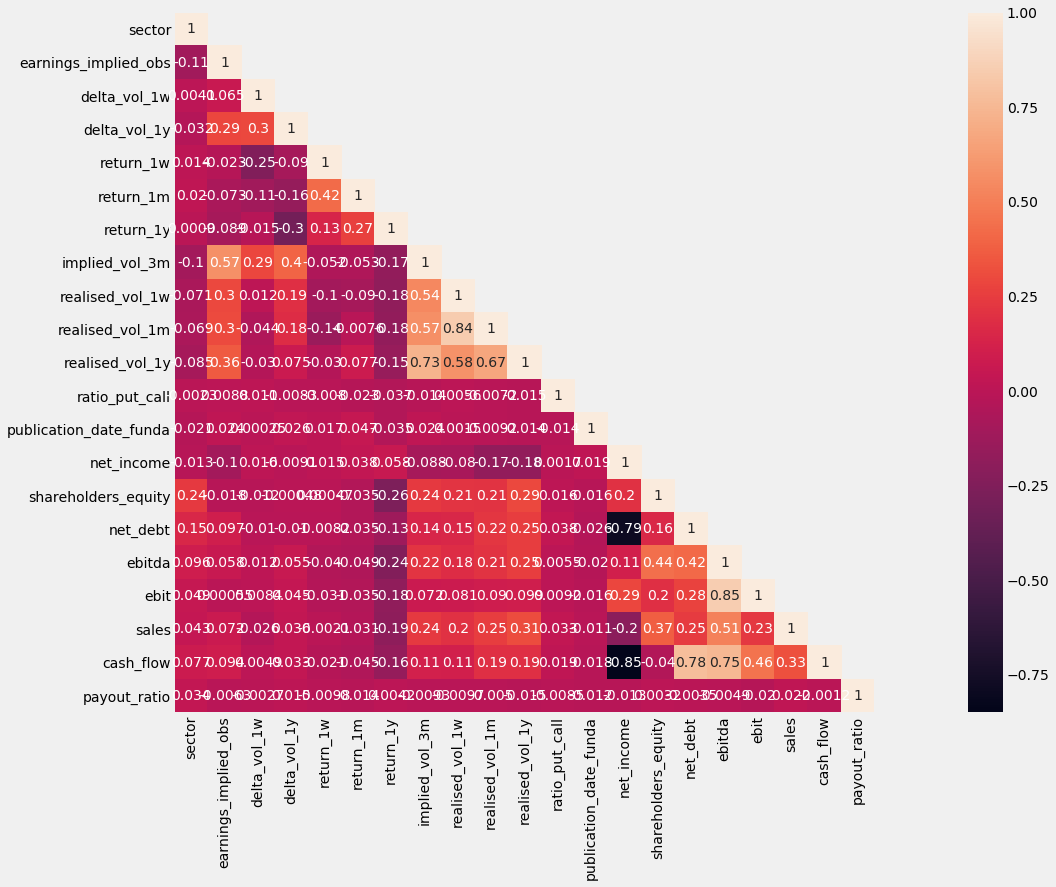

In [0]:
cor_mat= train_data[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

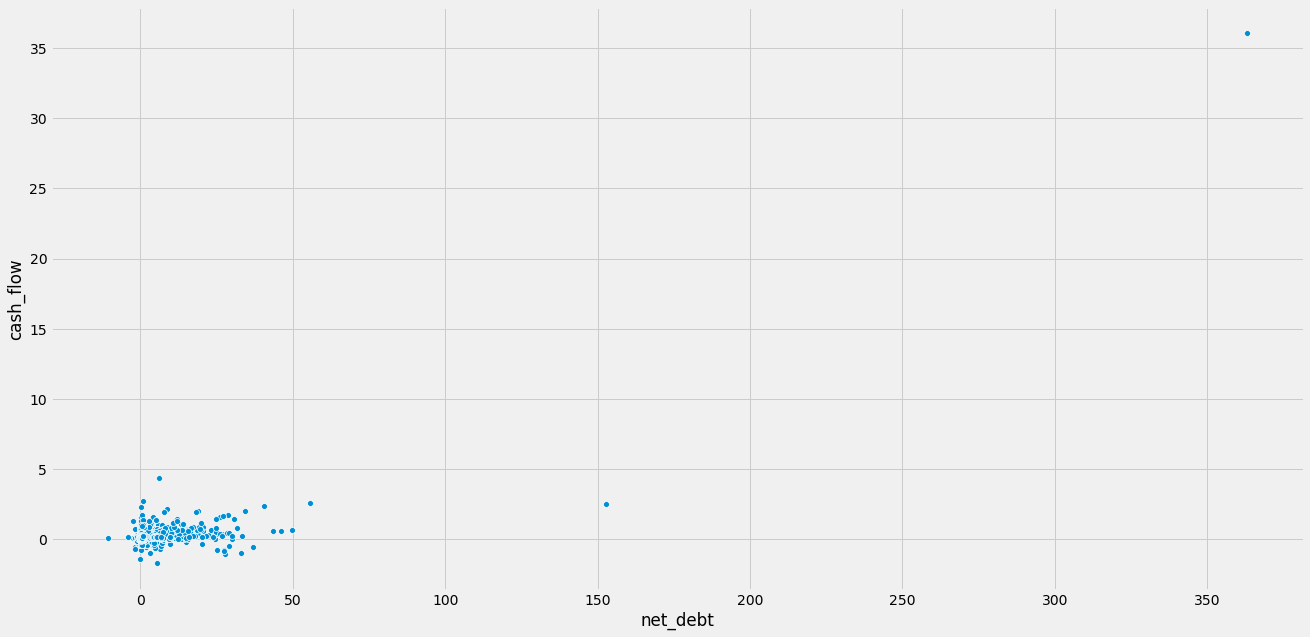

In [0]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='net_debt',y='cash_flow',data=train_data,palette='Set1')

In [0]:
import plotly.express as px
fig = px.scatter(train_data, x="net_debt", y="cash_flow", color="sector")
fig.show()

Text(0, 0.5, 'net_income')

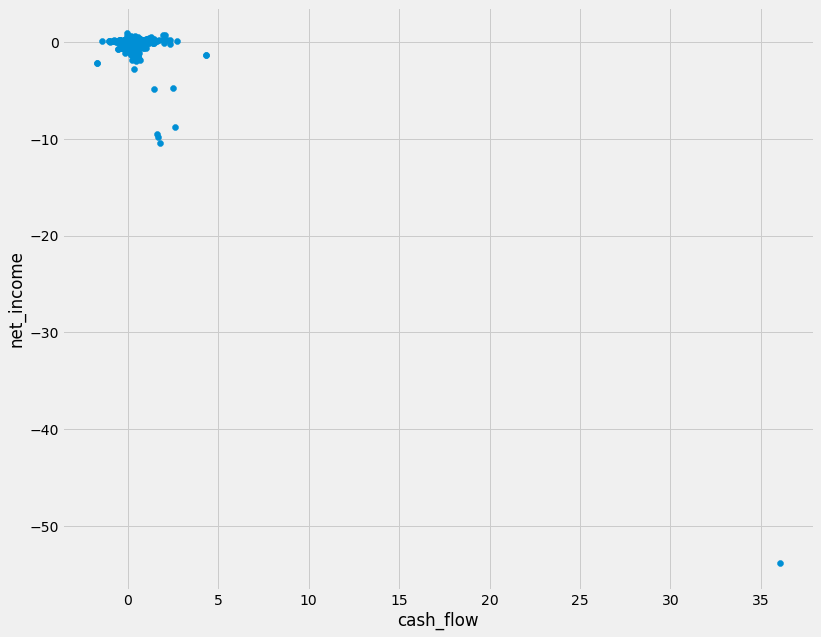

In [0]:
plt.figure(figsize=(12, 10))
plt.scatter(train_data['cash_flow'], train_data['net_income'])
plt.xlabel('cash_flow')
plt.ylabel('net_income')

Text(0, 0.5, 'return_1w')

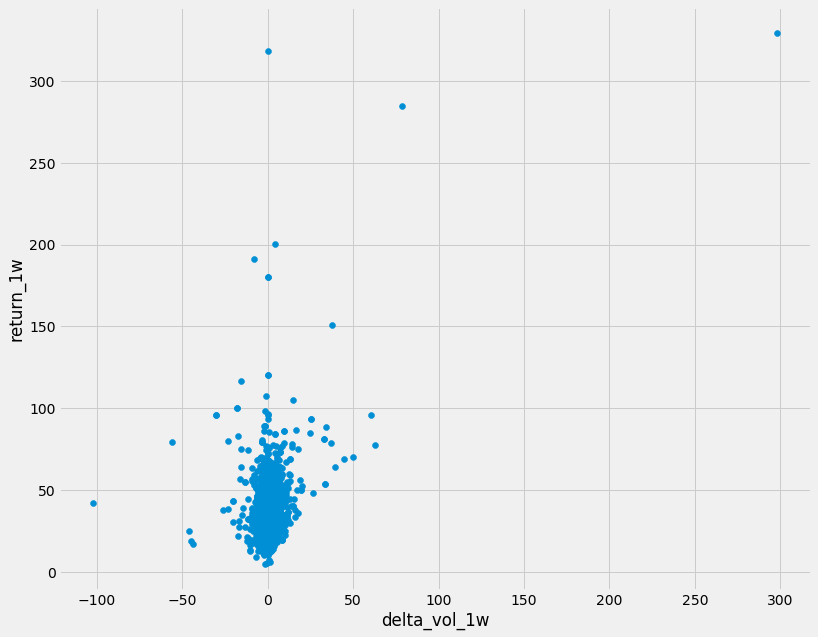

In [0]:
plt.figure(figsize=(12, 10))
plt.scatter(train_data['delta_vol_1w'], train_data['implied_vol_3m'])
plt.xlabel('delta_vol_1w')
plt.ylabel('return_1w')

In [0]:
def plot_lift_curve(y_true, y_prob, model_name, ax):
    """ Lift Curve """
    # Construct Lift Curve
    df = pd.DataFrame(np.array([y_true, y_prob]).T,columns=['true','soft'])
    df.sort_values(by='soft',ascending=False,inplace=True)
    lift = pd.concat([df.groupby('soft').count(),df.groupby('soft').sum()],axis=1)
    lift.sort_index(ascending=False,inplace=True)
    lift.columns = ['strate size','positive']
    lift['negative'] = lift['strate size'] - lift['positive']
    n_positive = df['true'].sum()
    n_negative = df['true'].count()-n_positive
    lift.index.name = 'threshold'
    lift['Group size'] = lift['strate size'].cumsum()
    lift['Group hit probability'] = lift['positive'].cumsum() / lift['Group size']
    lft = lift['Group hit probability'].values / (n_positive /(n_positive+n_negative))
    gr = lift['Group size'].values / len(y_true)
    mx = np.max(lft * (gr >= 0.1))

    # Plot Lift Curve
    label_name = '{}'.format(model_name)
    ax.plot(gr, lft, color='blue', label=label_name)
    ax.axhline(1.0, color='red', ls='--', label='Random guess')
    ax.set_title('Lift Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Decile', fontsize=13)
    ax.set_ylabel('Lift', fontsize=13)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.3*mx))
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_roc_curve(y_true, y_prob, model_name, ax):
    """ ROC Curve """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    label_name = '{} (AUC={})'.format(model_name, round(roc_auc, 2))
    ax.plot(fpr, tpr, color='blue', label=label_name)
    ax.plot([0, 1], [0, 1], color='red', ls='--', label='Random guess')
    ax.set_title('ROC Curve', fontsize=13, weight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True)
    return ax

def plot_precision_recall_curve(y_true, y_prob, model_name, ax):
    """ Precision-Recall Curve """
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    label_name = '{} (AP={})'.format(model_name, round(ap, 2))
    ax.plot(precision, recall, color='blue', label=label_name)
    ax.axhline(ap, color='red', ls='--', label='Average precision')
    ax.set_title('Precision Recall Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Precision', fontsize=13)
    ax.set_ylabel('Recall', fontsize=13)
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_discrimination_threshold(y_true, y_prob, ax):
    """ Discrimination Threshold Plot """
    # Test Multiple Thresholds
    thresholds = np.arange(0.001, 0.999, 0.1)
    precisions, recalls, f1_scores = [], [], []
    for t in thresholds:
        y_pred_temp = (y_prob > t).astype(int)
        precision_temp = precision_score(y_true, y_pred_temp)
        recall_temp = recall_score(y_true, y_pred_temp)
        f1_score_temp = f1_score(y_true, y_pred_temp)
        precisions.append(precision_temp)
        recalls.append(recall_temp)
        f1_scores.append(f1_score_temp)

    # Plot
    ap = average_precision_score(y_true, y_prob)
    ax.plot(thresholds, precisions, color='blue', label='Precision')
    ax.plot(thresholds, recalls, color='darkorange', label='Recall')
    ax.plot(thresholds, f1_scores, color='green', label='$F_1$ Score')
    ax.axhline(ap, color='red', ls='--', label='Avg. Precision')
    ax.legend(loc='best')
    ax.set_xlabel('Threshold', fontsize=13)
    ax.set_title('Binary Classification Threshold', fontsize=13, weight='bold')
    return ax

# **Exploratory Data Analysis**

In [0]:
train_data = train_data.drop('raw_id', axis=1)

KeyError: ignored

## Missing Values

In [0]:
train_data.isnull().sum().sort_values() / len(train_data)

sector                    0.000000
exchange                  0.000000
return_1y                 0.000066
return_1m                 0.000066
return_1w                 0.000066
realised_vol_1y           0.000131
realised_vol_1w           0.000197
realised_vol_1m           0.000197
implied_vol_3m            0.000328
delta_vol_1w              0.000656
publication_date_funda    0.000984
net_income                0.001115
sales                     0.001180
earnings_implied_obs      0.001312
net_debt                  0.001312
shareholders_equity       0.001377
cash_flow                 0.001705
payout_ratio              0.006164
ratio_put_call            0.006230
delta_vol_1y              0.014952
ebit                      0.122303
ebitda                    0.122565
dtype: float64

## Categorical & Numerical Variables

In [0]:
train_data.nunique().sort_values()

exchange                      2
sector                       20
publication_date_funda      401
payout_ratio               5163
earnings_implied_obs      11224
ebitda                    12262
ebit                      12264
delta_vol_1w              13004
delta_vol_1y              13588
implied_vol_3m            13659
ratio_put_call            13971
sales                     14005
cash_flow                 14010
shareholders_equity       14013
net_debt                  14014
net_income                14017
return_1w                 14075
return_1y                 14077
realised_vol_1w           14080
return_1m                 14080
realised_vol_1m           14080
realised_vol_1y           14081
dtype: int64

In [0]:
# train_data['publication_date_funda']

In [0]:
categorical_variables = ['sector', 'exchange']
categorical_variables_plus = ['sector', 'exchange', 'publication_date_funda']
numerical_variables = [col for col in train_data.columns if col not in categorical_variables_plus]

In [0]:
print(len(numerical_variables))
print(len(categorical_variables_plus))

19
3


## Target Distribution

In [0]:
y = train_labels.values.squeeze()

In [0]:
np.mean(y)

0.26768968456947995

# **Feature Engineering**

## Categorical Features

**One-Hot Encoding = Linear Models**

In [0]:
%%time
train_data_ = train_data.drop('publication_date_funda', axis=1)

oneHotTransformer = OneHotEncoder(cols=categorical_variables)
oneHotTransformer.fit(train_data_)

X_train_cat = oneHotTransformer.transform(train_data_)
print(X_train_cat.shape)

(15249, 43)
Wall time: 150 ms


**Label Encoding = Random Forests + XGBoost + LightGBM**

In [0]:
%%time
labelTransformer = OrdinalEncoder(cols=categorical_variables_plus)
labelTransformer.fit(train_data)

X_train_cat_label = labelTransformer.transform(train_data)
print(X_train_cat_label.shape)

(15249, 22)
Wall time: 184 ms


**Target Encoding = All Models**

In [0]:
train_data.shape, y.shape

((15249, 22), (15249,))

In [0]:
%%time
targetEncoder = TargetEncoder(cols=categorical_variables_plus)
targetEncoder.fit(train_data, y)

X_train_cat_target = targetEncoder.transform(train_data)
print(X_train_cat_target.shape)

(15249, 22)
Wall time: 4.03 s


In [0]:
X_train_cat_target[categorical_variables_plus].head()

,sector,exchange,publication_date_funda
0,0.145929,0.257221,0.268765
1,0.145929,0.257221,0.120690
2,0.145929,0.257221,0.085714
3,0.145929,0.257221,0.272727
4,0.145929,0.257221,0.167883


## Missing Values

**Linear Models**

In [0]:
imputer = SimpleImputer(strategy='median')
X_train_linear = imputer.fit_transform(X_train_cat)
X_train_linear = pd.DataFrame(X_train_linear, columns=X_train_cat.columns,
                              index=X_train_cat.index)

In [0]:
X_train_linear.isnull().sum().sum()

0

**Random Forests**

In [0]:
X_train_rf = X_train_cat_label.fillna(-1)

**XGBoost + LightGBM**

In [0]:
X_train_boost = X_train_cat_label.copy()

## Feature Scaling

**Linear Models**

In [0]:
scaler = StandardScaler()
X_train_linear[numerical_variables] = \
            scaler.fit_transform(X_train_linear[numerical_variables])

In [0]:
# X_train_linear[numerical_variables].head()

**Random Forests + XGBoost + LightGBM**

In [0]:
# SKIP

# **Model Training**

In [0]:
print('Linear Models :\t', X_train_linear.shape)
print('Random Forests:\t', X_train_rf.shape)
print('Gradient Boost:\t', X_train_boost.shape)

Linear Models :	 (15249, 43)
Random Forests:	 (15249, 22)
Gradient Boost:	 (15249, 22)


## Logistic Regression

In [0]:
logit = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',
                           class_weight='balanced', random_state=RANDOM_STATE)

In [0]:
%%time
lr_scores = cross_val_score(logit, X=X_train_linear, y=y, cv=10,
                            verbose=0, scoring='roc_auc')
print(lr_scores)

[0.61134325 0.59825808 0.57998929 0.56538654 0.62322046 0.58702407
 0.58448532 0.55658997 0.55918591 0.59275292]
Wall time: 2.84 s


In [0]:
print('Mean CV:\t', np.mean(lr_scores))
print('StDev CV:\t', np.std(lr_scores))

Mean CV:	 0.5858235809887145
StDev CV:	 0.02066767068453942


In [0]:
# y_valid_pred_logit = cross_val_predict(logit, X_train_cat_target, y, cv=10,
#                                        method='predict_proba')[:,1]

In [0]:
# f, ax = plt.subplots(2, 2, figsize=(12,10))
# plot_lift_curve(y, y_valid_pred_logit, model_name='Logit', ax=ax[0,0])
# plot_roc_curve(y, y_valid_pred_logit, model_name='Logit', ax=ax[0,1])
# plot_precision_recall_curve(y, y_valid_pred_logit, model_name='Logit',
#                             ax=ax[1,0])
# plot_discrimination_threshold(y, y_valid_pred_logit, ax=ax[1,1])
# plt.show()

In [0]:
logit.fit(X_train_linear, y);

## Linear SVM

In [0]:
# linear_svc = LinearSVC(penalty='l2', C=1.0, class_weight='balanced',
#                        random_state=RANDOM_STATE)

linear_svc = SVC(C=1.0, class_weight='balanced', kernel='linear',
                 probability=True, random_state=RANDOM_STATE)

In [0]:
%%time
cv_scores = cross_val_score(linear_svc, X=X_train_linear, y=y, cv=2, verbose=0,
                            scoring='roc_auc')
print(cv_scores)

[0.57016205 0.57154247]
Wall time: 2min 27s


In [0]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.5708522617194658
StDev CV:	 0.0006902077513142313


In [0]:
# y_valid_pred_svm = cross_val_predict(linear_svc, X_std, y, cv=10, method='predict_proba')[:,1]

In [0]:
# f, ax = plt.subplots(2, 2, figsize=(12,10))
# plot_lift_curve(y, y_valid_pred_svm, model_name='SVM', ax=ax[0,0])
# plot_roc_curve(y, y_valid_pred_svm, model_name='SVM', ax=ax[0,1])
# plot_precision_recall_curve(y, y_valid_pred_svm, model_name='SVM',
#                             ax=ax[1,0])
# plot_discrimination_threshold(y, y_valid_pred_svm, ax=ax[1,1])
# plt.show()

In [0]:
linear_svc.fit(X_std, y);

## Gaussian Kernel SVM

In [0]:
nonlinear_svc = SVC(C=1.0, class_weight='balanced', kernel='rbf',
                    probability=True, gamma='auto', random_state=RANDOM_STATE)

In [0]:
cv_scores = cross_val_score(nonlinear_svc, X=X_std, y=y, cv=10, verbose=0, scoring='f1')
print(cv_scores)

[0.27777778 0.32786885 0.38235294 0.29508197 0.25806452 0.29508197
 0.37681159 0.53333333 0.42105263 0.46575342]


In [0]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.363317900574124
StDev CV:	 0.08499429594622651


## Random Forests

In [0]:
randomForestClassifier = RandomForestClassifier(n_estimators=500, class_weight='balanced',
                                                max_depth=8, random_state=RANDOM_STATE)

In [0]:
cv_scores = cross_val_score(randomForestClassifier, X=X_std, y=y, cv=10, verbose=0, scoring='f1')
print(cv_scores)

[0.25352113 0.19230769 0.23529412 0.14545455 0.18518519 0.125
 0.29032258 0.39344262 0.28125    0.33333333]


In [0]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.24351112042843598
StDev CV:	 0.08000901443856137


## LightGBM

## Stacking

# **Testing Set Predictions**

## Prepare Test Set

In [0]:
test_data_ = test_data.drop(['raw_id', 'publication_date_funda'], axis=1)

In [0]:
%%time
X_test_one_hot = oneHotTransformer.transform(test_data_)

Wall time: 49.9 ms


In [0]:
%%time
X_test_impute = imputer.transform(X_test_one_hot)

Wall time: 8.98 ms


In [0]:
X_test_impute = pd.DataFrame(X_test_impute, columns=X_test_one_hot.columns,
                             index=X_test_one_hot.index)

In [0]:
X_test_impute[numerical_variables] = \
        scaler.fit_transform(X_test_impute[numerical_variables])

**Prediction**

In [0]:
y_test_pred_logit = logit.predict_proba(X_test_impute)[:,1]

In [0]:
np.savetxt('Submits/model_qmi_01_logit.csv', y_test_pred_logit,
           fmt='%1.15f', delimiter='.')

## AAA

## AAA

## 5.2. Best Model